# Post-processing with autoencoder network

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels, plt_st

from data_utils import get_scalers
from image_utils import get_image_data
from submission_utils import submission_iterator, write_shp_from_polygons, write_shp_from_csv, write_shp_from_mask
from submission_utils import get_scaled_polygons, get_polygons, compute_label_image, get_data_csv
from submission_utils import rewrite_submission

In [4]:
import cv2

### Input data

In [5]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [6]:
CSV_FILE_NEW = "../results/sub_mix_20170304_2329.csv"
CSV_FILE_TRAIN = "../results/sub_model_1_20170304_1826_nan.csv"

In [7]:
ll = int(0.7 * len(TRAIN_IMAGE_IDS))
train_ids = TRAIN_IMAGE_IDS[:ll]
val_ids = TRAIN_IMAGE_IDS[ll:]
np.random.shuffle(train_ids)
np.random.shuffle(val_ids)

Setup data parameters

In [8]:
channels = np.array([4,])
n_channels = len(channels)

labels = np.array([4,])
n_labels = len(labels)

tile_size = (256, 256)

In [9]:
channels, labels

(array([4]), array([4]))

In [10]:
from xy_iterators.xy_tiles_iterator import tile_iterator
from xy_iterators.adapters import X_csv_adapter, label_11d_adapter, compute_X_csv_mean_std
from xy_iterators.utils import balance_classes, balance_classes_reset, random_rotations, random_noise

In [11]:
img_shape = (860*4, 860*4, n_channels)
feature_wise = True

# X_mean, X_std = compute_X_csv_mean_std(train_ids, CSV_FILE_TRAIN, img_shape, channels, feature_wise=feature_wise)

In [37]:
def generate_images(image_ids_to_use, batch_size):
    verbose = 0
    balance_classes_reset()
    while True:
        
        X = np.zeros((batch_size, len(channels))+tile_size[::-1], dtype=np.float32)
        Y = np.zeros((batch_size, len(labels))+tile_size[::-1], dtype=np.float32)
            
#         x_adapter = lambda image_id: X_csv_adapter(image_id, CSV_FILE_TRAIN, X_channels=channels, X_mean=X_mean, X_std=X_std)
        x_adapter = lambda image_id: label_11d_adapter(image_id, Y_channels=labels)
        
        y_adapter = lambda image_id: label_11d_adapter(image_id, Y_channels=labels)                
        
        balance_classes_func = lambda Y: balance_classes(Y, presence_percentage=0.15, verbose=verbose)
        random_transformation_func = lambda X, Y: random_rotations(X, Y, verbose=verbose)
        
        tiles = tile_iterator(image_ids_to_use, 
                              x_adapter, 
                              y_adapter,
                              balance_classes_func=balance_classes_func,
                              transformation_func=random_noise,
                              random_transformation_func=random_transformation_func,
                              n_images_same_time=5,
                              verbose=verbose)
        counter = 0
        for x, y in tiles:     
            
            x = x.transpose([2,0,1])
            y = y.transpose([2,0,1])
            
            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0


In [38]:
# train_ids = ['6120_2_0', '6100_2_2', '6010_1_2', '6040_4_4']

In [56]:
batch_size = 1
train_gen = generate_images(train_ids, batch_size)

(1, 1, 256, 256) (1, 1, 256, 256)
-2.11665 2.59532
0.0 1.0


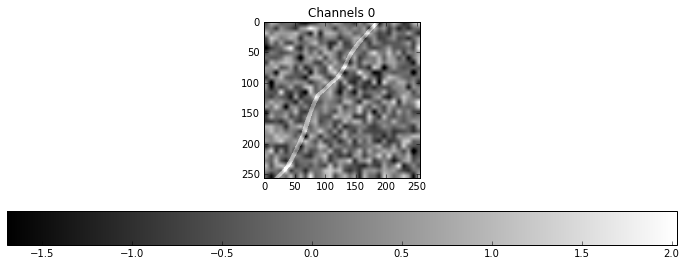

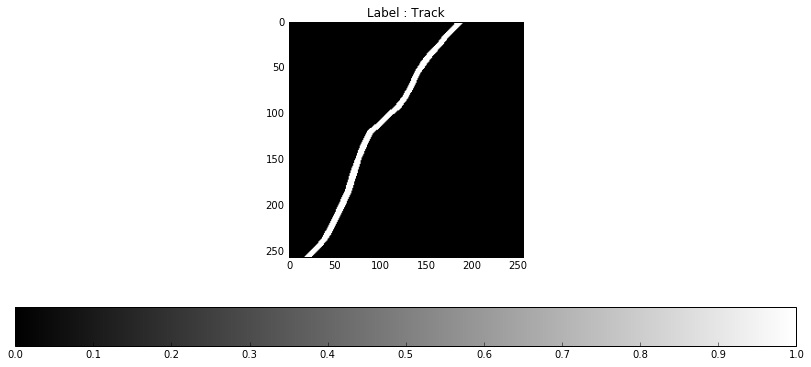

In [57]:
for X, Y in train_gen:
    print X.shape, Y.shape
    print X.min(), X.max()
    print Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [60]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from another_unet import unet_original

In [64]:
model = unet_original(n_labels, n_channels, *tile_size)

weights_filename = os.path.join("weights", "a_unit_o_%i_%i.h5" % (n_channels, n_labels))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [65]:
channels, labels

(array([4]), array([4]))

In [66]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 64, 128, 128)  640         input_2[0][0]                    
____________________________________________________________________________________________________
leakyrelu_8 (LeakyReLU)          (None, 64, 128, 128)  0           convolution2d_16[0][0]           
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 128, 64, 64)   73856       leakyrelu_8[0][0]                
___________________________________________________________________________________________

In [72]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
#earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# LearningRateScheduler

from keras import backend as K
def jaccard_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred))

In [73]:
# model.compile(optimizer=Adadelta(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])
model.compile(optimizer=Adadelta(lr=0.01), loss=jaccard_loss, metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [78]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 256
nb_val_samples = 64


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=150,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=1
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename + '.last')

4 256 64
Epoch 1/150
256/256 [==============================] - 188s - loss: 1.0936 - jaccard_coef: 0.3469 - jaccard_coef_int: 0.3688 - recall: 0.9461 - precision: 0.6644 - val_loss: 1.1193 - val_jaccard_coef: 0.3480 - val_jaccard_coef_int: 0.3690 - val_recall: 0.9400 - val_precision: 0.6703
Epoch 2/150
256/256 [==============================] - 182s - loss: 1.0830 - jaccard_coef: 0.3592 - jaccard_coef_int: 0.3811 - recall: 0.9454 - precision: 0.6646 - val_loss: 0.9152 - val_jaccard_coef: 0.4110 - val_jaccard_coef_int: 0.4372 - val_recall: 0.9480 - val_precision: 0.7519
Epoch 3/150
256/256 [==============================] - 182s - loss: 1.0933 - jaccard_coef: 0.3450 - jaccard_coef_int: 0.3641 - recall: 0.9557 - precision: 0.6435 - val_loss: 1.1619 - val_jaccard_coef: 0.3534 - val_jaccard_coef_int: 0.3759 - val_recall: 0.9434 - val_precision: 0.6708
Epoch 4/150
256/256 [==============================] - 182s - loss: 1.1355 - jaccard_coef: 0.3302 - jaccard_coef_int: 0.3471 - recall: 0.95

In [79]:
batch_size = 5
val_gen = generate_images(val_ids, batch_size)

(5, 1, 256, 256) 1.0191e-11 1.0


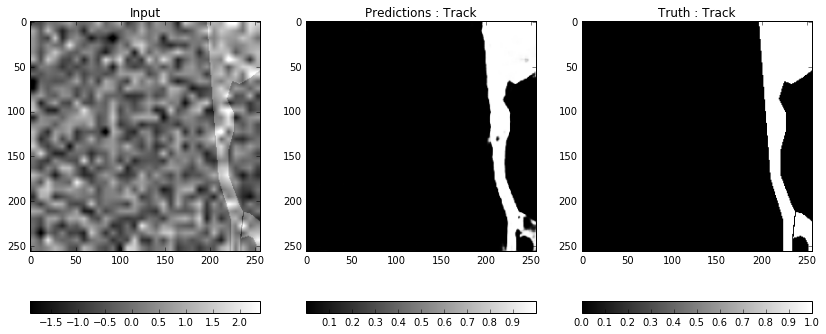

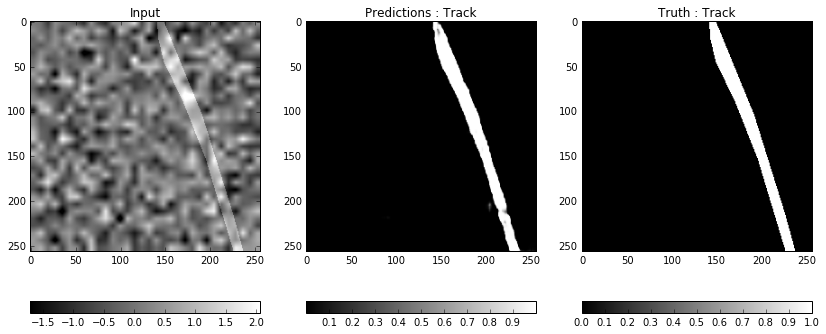

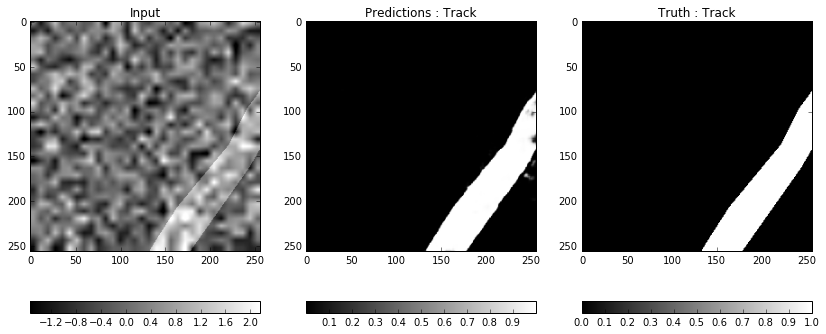

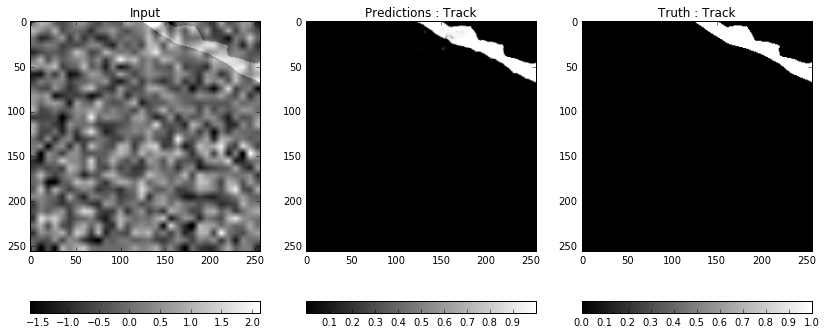

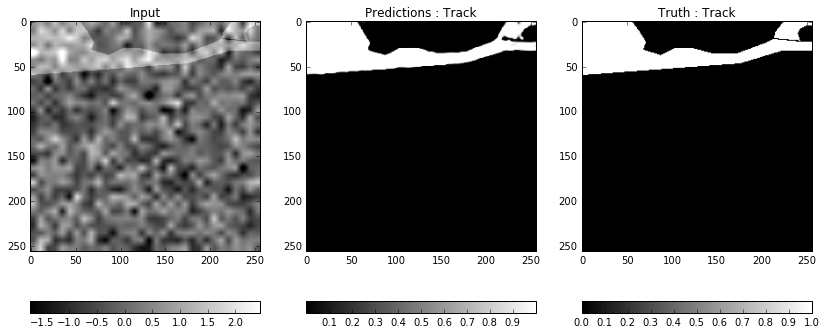

In [80]:
for X, Y in val_gen:
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(131)
        display_img_1b(X[i,0,:,:])
        plt.title("Input")

        plt.subplot(132)
        display_img_1b(Y_pred[i,0,:,:])
        plt.title("Predictions : %s" % LABELS[labels[j]])

        plt.subplot(133)
        display_img_1b(Y[i,0,:,:])
        plt.title("Truth : %s" % LABELS[labels[j]])

    break

In [84]:
def generate_images2(image_ids_to_use, batch_size):
    verbose = 0
    balance_classes_reset()
    while True:
        
        X = np.zeros((batch_size, len(channels))+tile_size[::-1], dtype=np.float32)
        Y = np.zeros((batch_size, len(labels))+tile_size[::-1], dtype=np.float32)
            
        x_adapter = lambda image_id: X_csv_adapter(image_id, CSV_FILE_TRAIN, X_channels=channels, X_mean=None, X_std=None)
#         x_adapter = lambda image_id: label_11d_adapter(image_id, Y_channels=labels)
        
        y_adapter = lambda image_id: label_11d_adapter(image_id, Y_channels=labels)                
        
        balance_classes_func = lambda Y: balance_classes(Y, presence_percentage=0.15, verbose=verbose)
        random_transformation_func = lambda X, Y: random_rotations(X, Y, verbose=verbose)
        
        tiles = tile_iterator(image_ids_to_use, 
                              x_adapter, 
                              y_adapter,
                              balance_classes_func=balance_classes_func,
                              transformation_func=random_noise,
                              random_transformation_func=random_transformation_func,
                              n_images_same_time=5,
                              verbose=verbose)
        counter = 0
        for x, y in tiles:     
            
            x = x.transpose([2,0,1])
            y = y.transpose([2,0,1])
            
            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0


In [85]:
batch_size = 5
val_gen = generate_images2(val_ids, batch_size)

(5, 1, 256, 256) 9.11781e-12 1.0


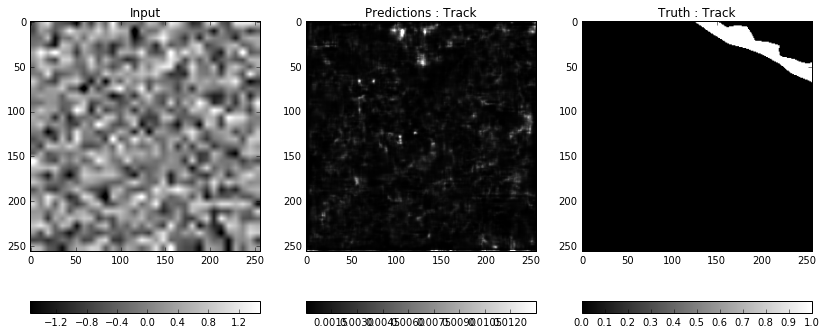

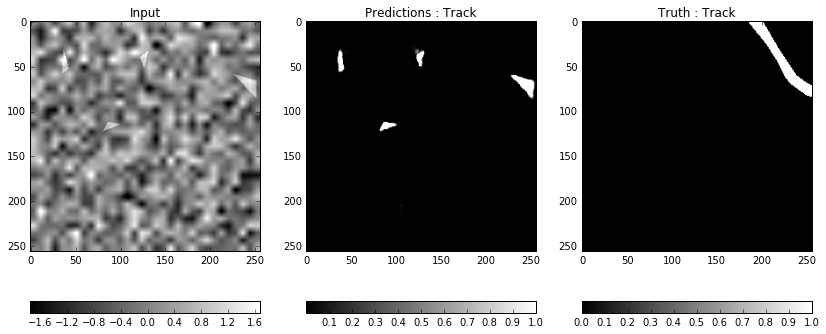

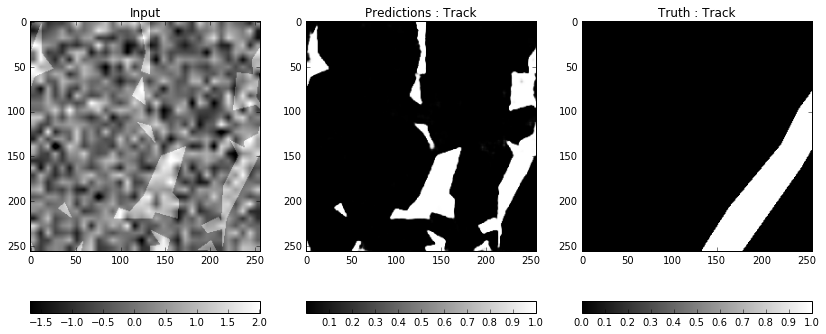

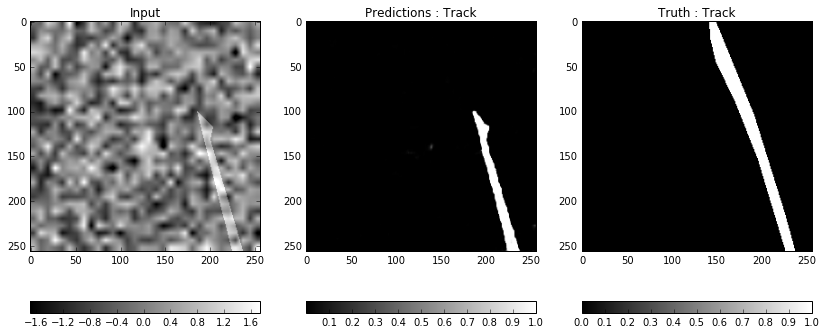

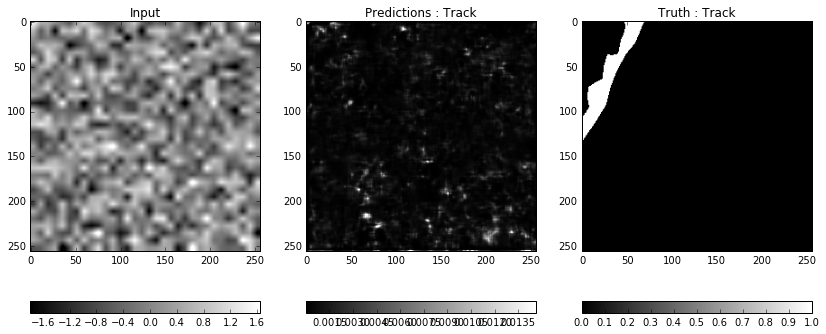

In [86]:
for X, Y in val_gen:
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(131)
        display_img_1b(X[i,0,:,:])
        plt.title("Input")

        plt.subplot(132)
        display_img_1b(Y_pred[i,0,:,:])
        plt.title("Predictions : %s" % LABELS[labels[j]])

        plt.subplot(133)
        display_img_1b(Y[i,0,:,:])
        plt.title("Truth : %s" % LABELS[labels[j]])

    break